In [1]:
!pip install pystan
!pip install fbprophet
#!pip install pmdarima

In [2]:
#Importing libraries
import numpy as np 
from scipy.stats import randint
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
%matplotlib inline
import matplotlib as mpl
from fbprophet import Prophet
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm


In [3]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv     dataframe_flow_variable_1D.csv     DMA_468.csv
dataframe_dma_flow_60min.csv  dataframe_flow_variable_60min.csv
dataframe_flow_1D.csv         DMA_225.csv


In [5]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/DMA_225.csv")
data['Date-time'] = pd.to_datetime(data['Date-time'], dayfirst=True, errors='coerce')

In [6]:
data.rename( columns={'Flow':'DMA_225','Date-time':'Date_time'}, inplace=True )
data_DMA225 = data[['Date_time','DMA_225']]

In [7]:
figure = px.line(data_DMA225,x="Date_time",y="DMA_225",title="DMA_225 with slider")
figure.update_xaxes(rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="12m",
                     step="month",
                     stepmode="backward"),
                dict(count=2,
                     label="8m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="4m",
                     step="month",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        )
    )
figure.show()

In [8]:
data_DMA225_indexed = data_DMA225.set_index('Date_time')
hourly_data = data_DMA225_indexed.resample('h').sum()

# Stationarity check

In [9]:
#Statistical information
hourly_data.describe()

,DMA_225
count,8760.000000
mean,14.605825
std,9.939253
min,0.000000
25%,8.001000
50%,13.888000
75%,19.444000
max,237.554001


<Figure size 1584x720 with 0 Axes>

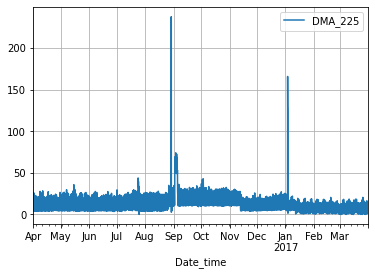

<Figure size 1584x720 with 0 Axes>

In [10]:
# Looking at plots
DMA225_df_indexed = hourly_data[['DMA_225']]
DMA225_df_indexed.plot(grid=True)
plt.figure(figsize=(22,10))

In [11]:

# Augmented Dickey-Fuller test
#Null Hypothesis (H0): If failed to be rejected, meaning it is non-stationary. It has some time dependent structure.
#Alternate Hypothesis (H1): The null hypothesis is rejected;  meaning it is stationary. It does not have time-dependent structure.

ADF_Check_Stationary = adfuller(hourly_data)
print('ADF Statistic: %f' % ADF_Check_Stationary[0])
print('p-value: %f' % ADF_Check_Stationary[1])
print('Critical Values:')
for key, value in ADF_Check_Stationary[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.013940
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Observation :

1.The ADF statistic value of -7. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

2.p value - 0.000058 < 0.05 ; Data is stationary

In [12]:
#Kwiatkowski-Phillips-Schmidt-Shin test
#Null Hypothesis (H0): stationary.
#Alternate Hypothesis (H1): non-stationary

KPSS_Check_Stationary = kpss(hourly_data)
KPSS_Check_Stationary

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




(4.311493604916821,
 0.01,
 37,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

Observation : 1.The ADF statistic value of 4.3. The positive value is statistic, and hence we have a stationary dataset.

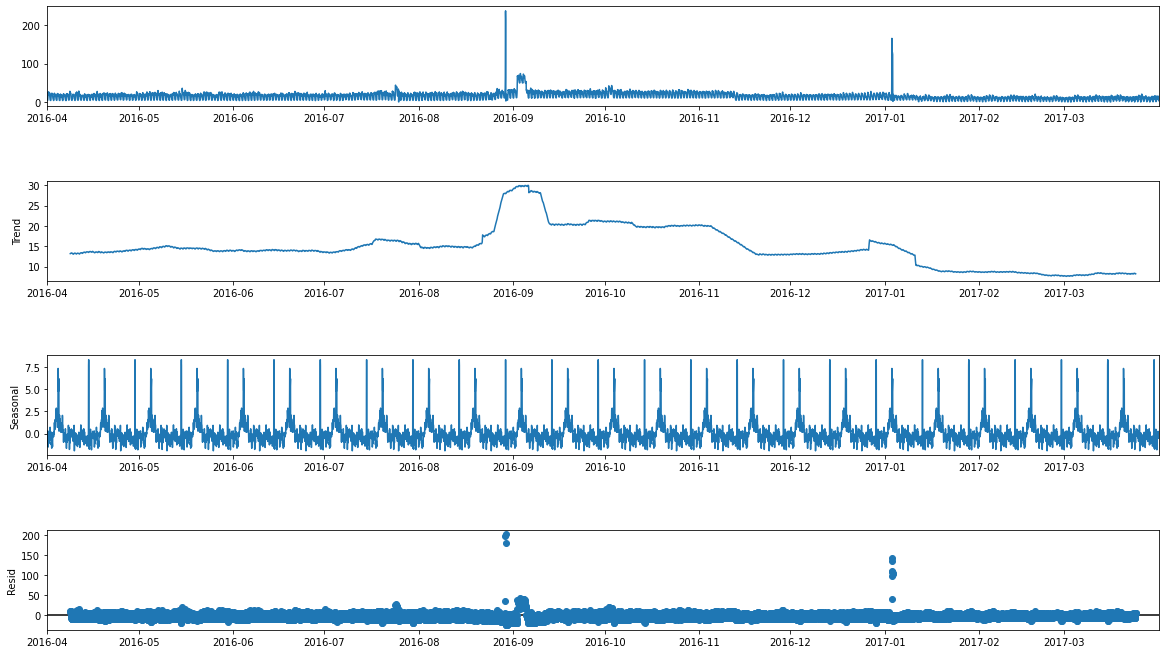

In [13]:
res=sm.tsa.seasonal_decompose(hourly_data,period=365)
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(18)
plt.show()

In [14]:
#Resetting index
hourly_data_index = hourly_data.reset_index()
#Renaming columns
hourly_data_index = hourly_data_index.rename(columns= {'Date_time': 'ds', 'DMA_225':'y'})
hourly_data_index.shape

(8760, 2)

In [15]:
#general Information
data_DMA225_indexed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35040 entries, 2016-04-01 00:00:00 to 2017-03-31 23:45:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DMA_225  35032 non-null  float64
dtypes: float64(1)
memory usage: 547.5 KB


In [16]:
# Making hourly data 
hourly_data = data_DMA225_indexed.resample('h').sum()

In [17]:
#Resetting index
hourly_data_index = hourly_data.reset_index()
#Renaming columns
hourly_data_index = hourly_data_index.rename(columns= {'Date_time': 'ds', 'DMA_225':'y'})
hourly_data_index.shape

(8760, 2)

In [18]:
#Train and test split
step_out = 24
train = hourly_data_index[:len(hourly_data_index)-step_out]
test = hourly_data_index[len(hourly_data_index)-step_out:]

In [19]:
#Instatntiate model
model = Prophet()
#Train
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [20]:
# Forecast / Predict

future_prediction = model.make_future_dataframe(periods = test.shape[0], freq = '1H')  
forecast_prediction = model.predict(test)
forecast_prediction[['ds', 'yhat']]

,ds,yhat
0,2017-03-31 00:00:00,0.108295
1,2017-03-31 01:00:00,-0.886351
2,2017-03-31 02:00:00,-1.827873
3,2017-03-31 03:00:00,-2.093959
4,2017-03-31 04:00:00,-0.840422
5,2017-03-31 05:00:00,2.294233
6,2017-03-31 06:00:00,6.729831
7,2017-03-31 07:00:00,11.133190
8,2017-03-31 08:00:00,14.146769
9,2017-03-31 09:00:00,15.130218


In [21]:
dataList_test = list(test.y.values)

In [22]:
#Calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(dataList_test,forecast_prediction['yhat']))
rmse = round(rmse, 3)
print (" The root mean square vakue on testset: ",rmse)

 The root mean square vakue on testset:  3.116


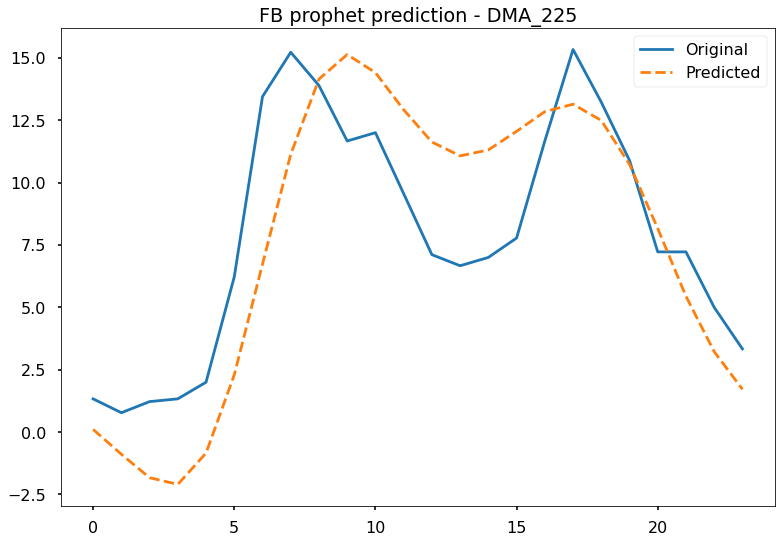

In [23]:
plt.style.use('seaborn-poster')
plt.figure()
plt.plot(dataList_test, label='Original')
plt.plot(forecast_prediction['yhat'].values, ls='--', label="Predicted")
plt.legend(loc='best')
plt.title('FB prophet prediction - DMA_225')
plt.show()